In [1]:
import warnings

warnings.filterwarnings("ignore")

## Quickstart

* typical business use case :-)
* here's some monthly historic sales data

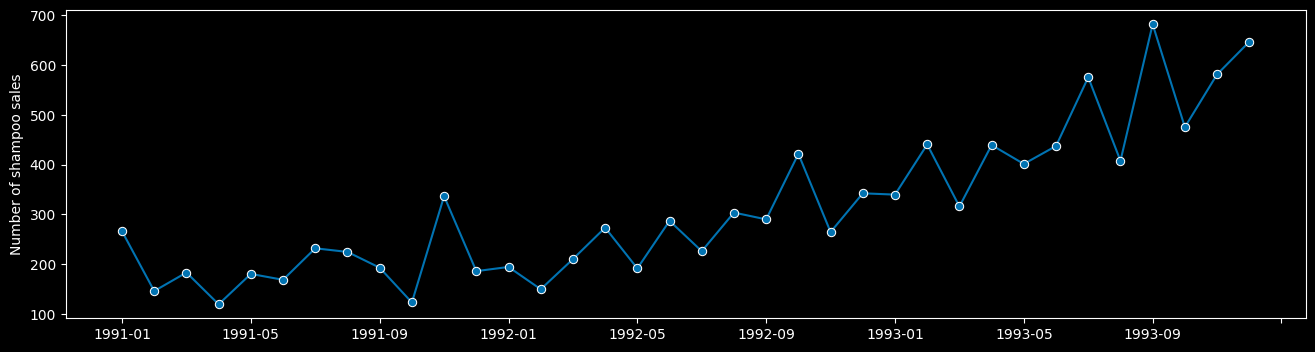

In [2]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series

y = load_shampoo_sales()

_ = plot_series(y)

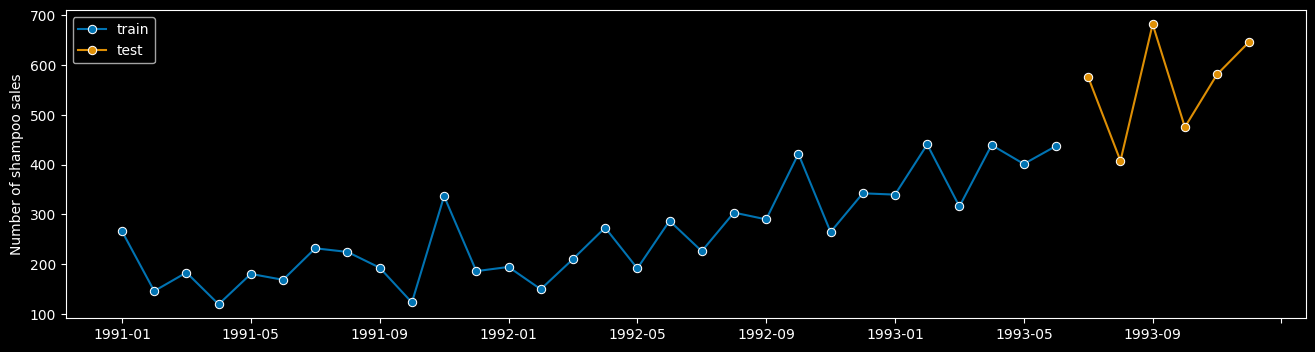

In [3]:
from sktime.split import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y=y, test_size=6)
_ = plot_series(y_train, y_test, labels=["train", "test"])

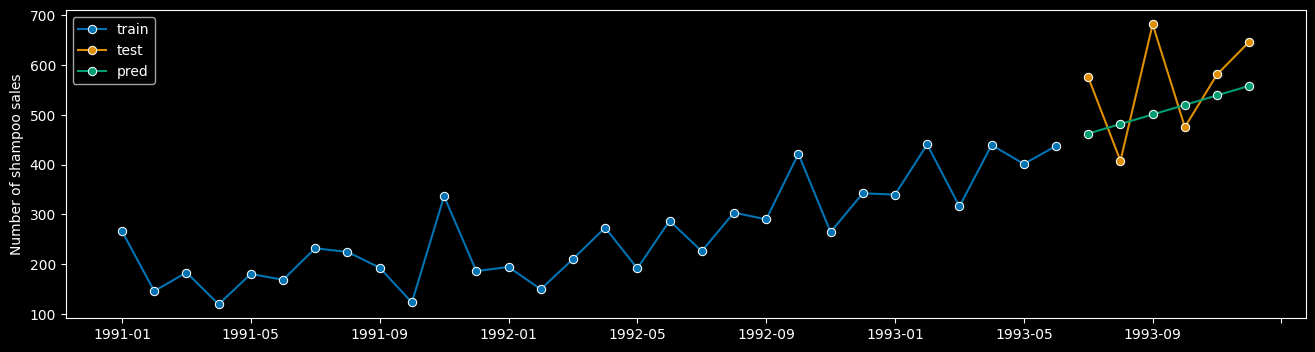

In [4]:
from sktime.forecasting.ets import AutoETS

# 1) Define the model
forecaster = AutoETS(auto=True)

# 2) Fit on train data
forecaster.fit(y_train)

# 3) Use fitted model to predict for a certain forecast horizon (fh)
fh = [1, 2, 3, 4, 5, 6]  # Relative to y_train
y_pred = forecaster.predict(fh)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"])

* scoring using `sktime` performance metrics
* requires forecasts & true values as `sktime` compatible time series

In [5]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

print(f"AutoARIMA - sMAPE error: {smape(y_test, y_pred):.1%}")

AutoARIMA - sMAPE error: 16.7%


Notes:

* MAPE just for illustration - not always best choice
* for robust evaluation & comparison, use backtesting (not single train/test split)

### Probabilistic Forecasting

The following methods are possibly available for probabilistic forecasts:

- `predict_interval` produces interval forecasts. Additionally to any `predict` arguments, an argument `coverage` (nominal interval coverage) must be provided.
- `predict_quantiles` produces quantile forecasts. Additionally to any `predict` arguments, an argument `alpha` (quantile values) must be provided.
- `predict_var` produces variance forecasts. This has same arguments as `predict`.
- `predict_proba` produces full distributional forecasts. This has same arguments as `predict`.

| Name | param | prediction/estimate of | `sktime` |
| ---- | ----- | ---------------------- | -------- |
| point forecast | | conditional expectation $\mathbb{E}[y'\|y]$ | `predict` |
| variance forecast | | conditional variance $Var[y'\|y]$ | `predict_var` |
| quantile forecast | $\alpha\in (0,1)$ | $\alpha$-quantile of $y'\|y$ | `predict_quantiles` |
| interval forecast | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y' \le b\| y) = c$ | `predict_interval` |
| distribution forecast | | the law/distribution of $y'\|y$ | `predict_proba` |

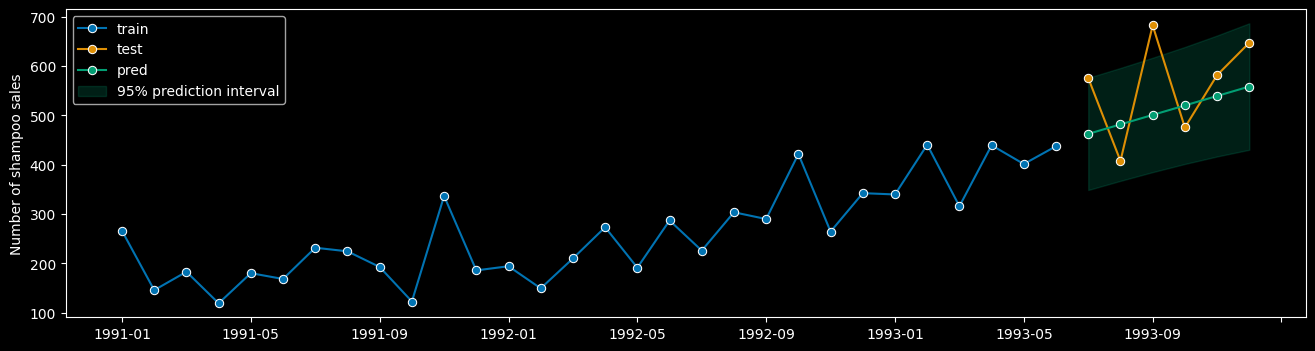

In [6]:
# 4) Call a probabilistic method after or in place of step 3
y_pred_int = forecaster.predict_interval(coverage=0.95)

fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["train", "test", "pred"], pred_interval=y_pred_int
)

## Exogenous Features

In [7]:
from sktime.datasets import load_longley

y, X = load_longley()

In [8]:
X.tail()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1958,110.8,444546.0,4681.0,2637.0,121950.0
1959,112.6,482704.0,3813.0,2552.0,123366.0
1960,114.2,502601.0,3931.0,2514.0,125368.0
1961,115.7,518173.0,4806.0,2572.0,127852.0
1962,116.9,554894.0,4007.0,2827.0,130081.0


In [9]:
from sktime.split import temporal_train_test_split

y_train, y_test, X_train, X_test = temporal_train_test_split(y=y, X=X, test_size=4)

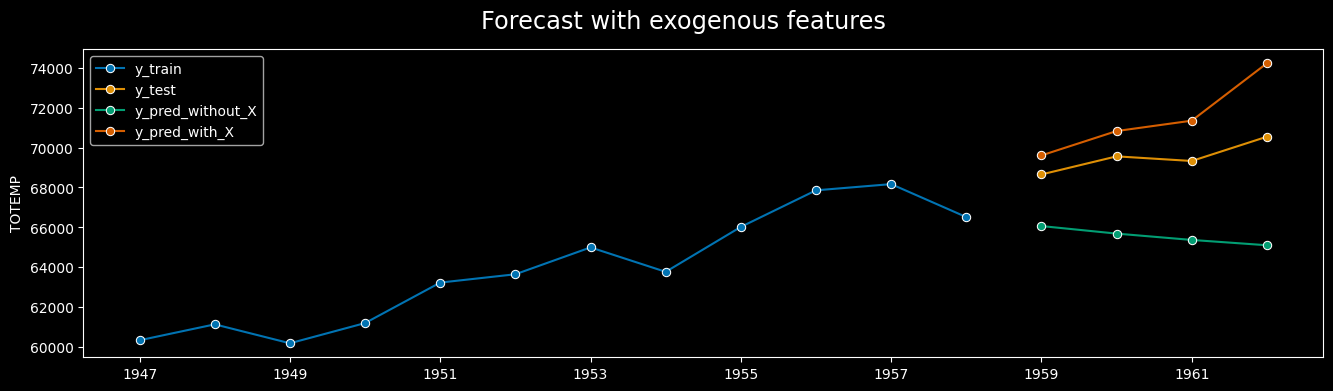

In [10]:
from sktime.forecasting.arima import ARIMA

forecaster_without_X = ARIMA()
forecaster_with_X = ARIMA()

forecaster_without_X.fit(y_train, fh=[1, 2, 3, 4])
forecaster_with_X.fit(y_train, X=X_train, fh=[1, 2, 3, 4])

y_pred_without_X = forecaster_without_X.predict()
y_pred_with_X = forecaster_with_X.predict(X=X_test)

_ = plot_series(
    y_train,
    y_test,
    y_pred_without_X,
    y_pred_with_X,
    labels=["y_train", "y_test", "y_pred_without_X", "y_pred_with_X"],
    title="Forecast with exogenous features",
)

In [11]:
print(f"ARIMA without X - sMAPE error: {smape(y_test, y_pred_without_X):.1%}")

ARIMA without X - sMAPE error: 5.9%


In [12]:
print(f"ARIMA with X - sMAPE error: {smape(y_test, y_pred_with_X):.1%}")

ARIMA with X - sMAPE error: 2.8%


## Multivariate forecasting

We begin by loading the historical data of a couple of macro indicators, which are reported yearly.

In [13]:
y = X[["GNPDEFL", "GNP"]]

In `sktime` some forecasters such as `VAR()` are purely mutlivariate. Let's use it to make some predictions:

In [14]:
from sktime.forecasting.var import VAR

forecaster = VAR()
forecaster.fit(y, fh=[1, 2, 3])

y_pred = forecaster.predict()
y_pred

,GNPDEFL,GNP
Period,,
1963,121.688295,578514.398653
1964,124.353664,601873.015890
1965,126.847886,625411.588754


But we can also use univariate forecasters to forecast multiple time series! Let's see how this is done using `ARIMA` which is a purely univariate model.

In [15]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing()
forecaster.fit(y, fh=[1, 2, 3])

y_pred = forecaster.predict()
y_pred

/home/anirban/conda-environments/pydata/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,GNPDEFL,GNP
Period,,
1963,116.9,554710.003189
1964,116.9,554710.003189
1965,116.9,554710.003189


In [16]:
forecaster.forecasters_

,GNPDEFL,GNP
forecasters,ExponentialSmoothing(),ExponentialSmoothing()


# Forecasting Pipelines

Until now: How can we use sktime to create forecasts.

Now: How can we improve the forecasts.

* endogenous transformation pipelines via `TransformedTargetForecaster`
* exogenous transformation pipelines via `ForecastingPipeline`
* feature extraction compositors
    * `FeatureUnion` and `ColumnSelect` for multiple feature extraction
    * `ColumnEnsembleForecaster` and `ColumnEnsembleTransformer` to apply per variable
* forecasting exogenous variables via `ForecastX`

suppose we want to forecast this well-known dataset
(airline passengers by year in a fixed scope)

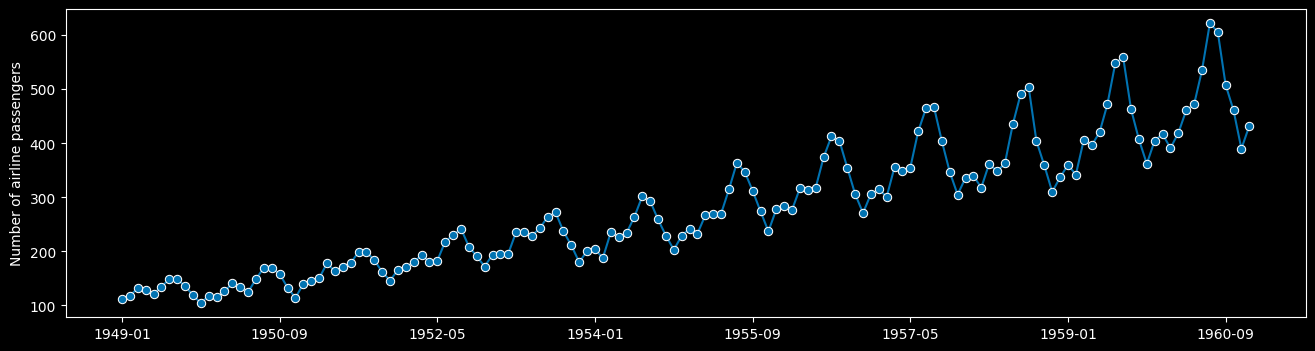

In [17]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()
_ = plot_series(y)

observations:

* there is monthly seasonality - resets annually - periodicity 12
* trend and seasonality are multiplicative (not additive)

idea: forecast might be easier

* on logarithmic value scale (multiplication becomes addition)
* with seasonality removed

### Manual tranformations: doing things the hard way

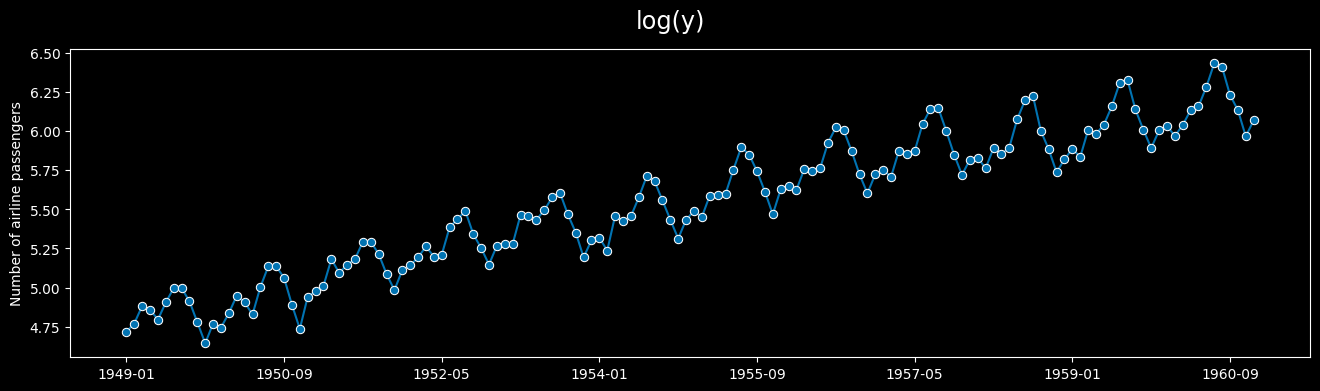

In [18]:
import numpy as np

y_log = np.log(y)

_ = plot_series(y_log, title="log(y)")

this looks additive now!

ok, what next - deaseasonalization

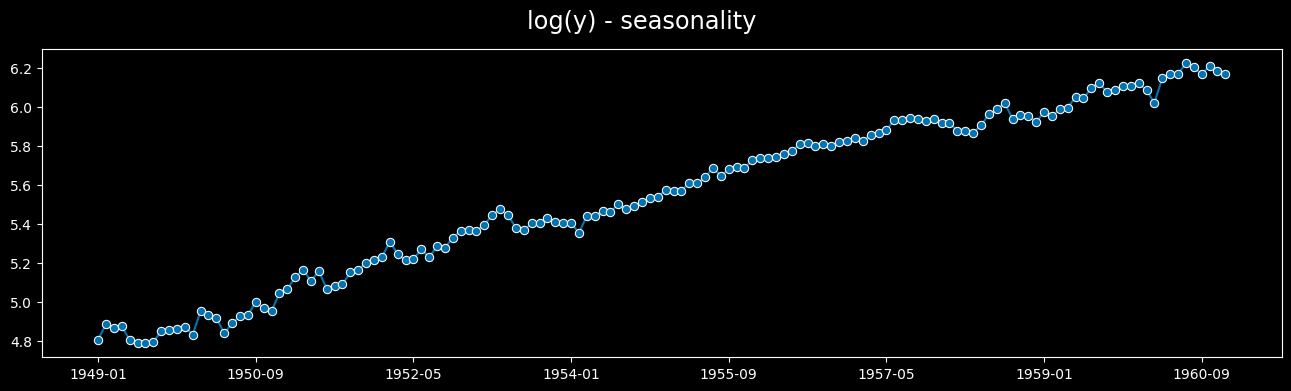

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_result = seasonal_decompose(y_log, period=12)
seasonal = seasonal_result.seasonal
y_log_deseasonalised = y_log - seasonal

_ = plot_series(y_log_deseasonalised, title="log(y) - seasonality")

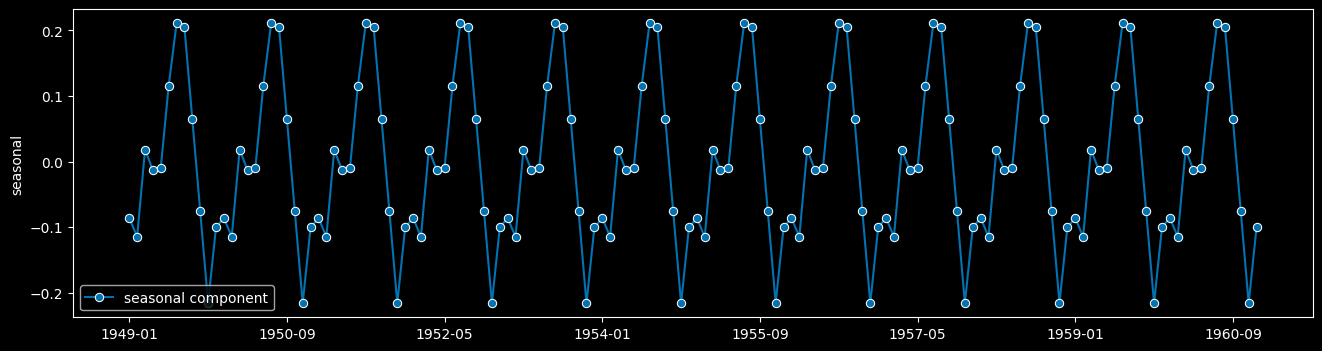

In [20]:
_ = plot_series(seasonal, labels=["seasonal component"])

now:

* forecast on this
* add back seasonal component
* invert logarithm (exponentiate)

start with forecast...

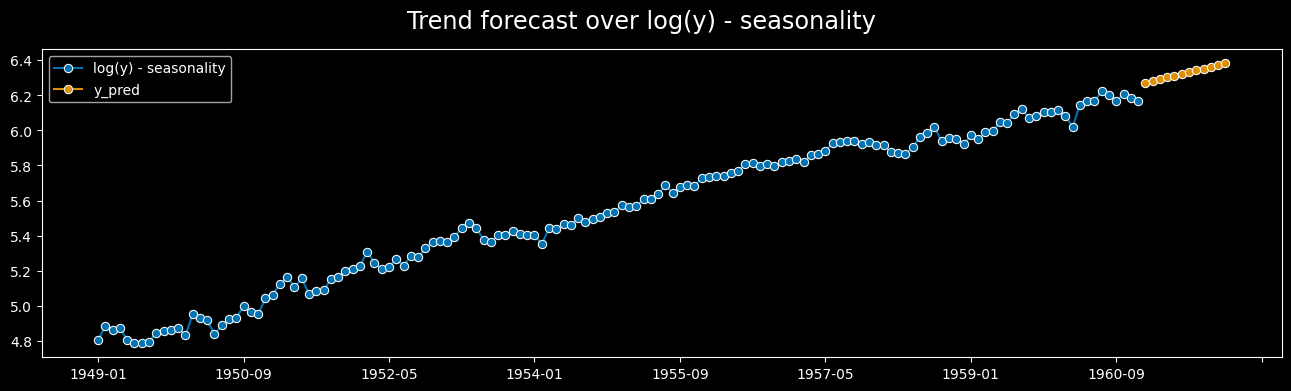

In [21]:
from sktime.forecasting.trend import TrendForecaster

forecaster = TrendForecaster()

fh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # Alternatively: range(1, 12 + 1)
y_pred = forecaster.fit_predict(y_log_deseasonalised, fh=fh)

fig, ax = plot_series(
    y_log_deseasonalised,
    y_pred,
    labels=["log(y) - seasonality", "y_pred"],
    title="Trend forecast over log(y) - seasonality",
)

looks reasonable!

Now to turn this into a forecast of the original y ...

* add seasonal
* invert the logarithm

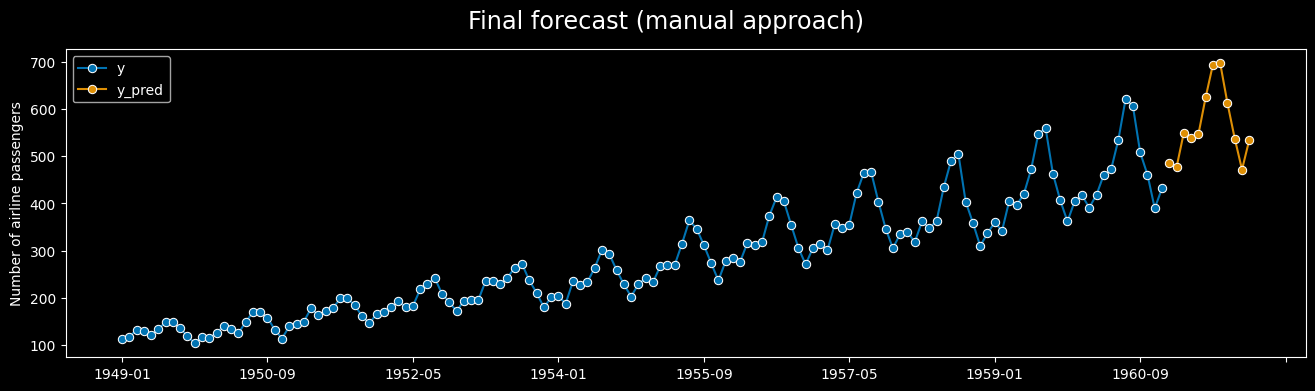

In [22]:
y_pred_add_seasonality = y_pred + seasonal.to_numpy()[:12]
y_pred_orig = np.exp(y_pred_add_seasonality)

_ = plot_series(y, y_pred_orig, labels=["y", "y_pred"], title="Final forecast (manual approach)")

### 3.1.2 `sktime` transformers: doing things the easier way


Solution: use transformers & pipelines!

Same interface at every step! Easily composable!


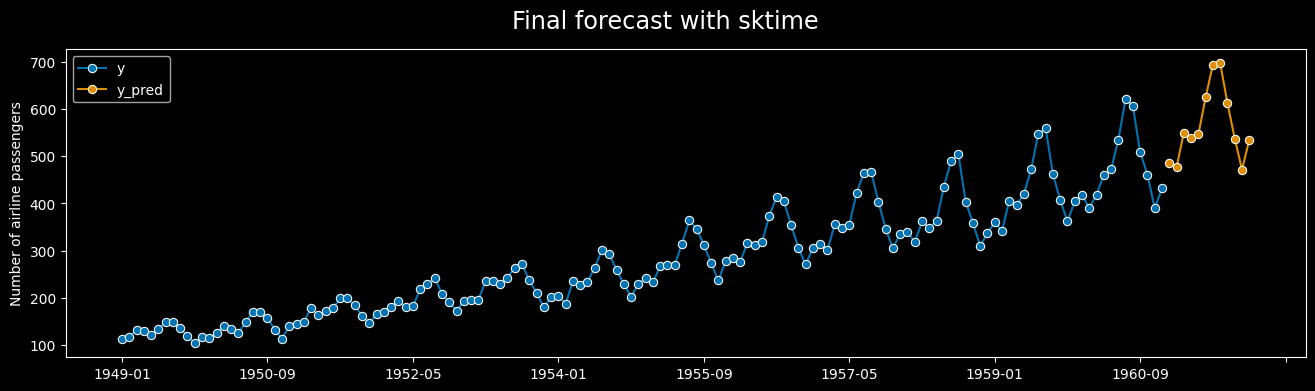

In [23]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.trend import TrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

take_log = LogTransformer()
remove_seasonality = Deseasonalizer(sp=12)
trend_forecaster = TrendForecaster()

forecaster_explicit = TransformedTargetForecaster([take_log, remove_seasonality, trend_forecaster])

fh = range(1, 12 + 1)
y_pred = forecaster_explicit.fit_predict(y, fh=fh)

_ = plot_series(y, y_pred, labels=["y", "y_pred"], title="Final forecast with sktime")

### Dunder magic

In [24]:
forecaster_dunder = take_log * remove_seasonality * trend_forecaster

forecaster_dunder

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   TrendForecaster()])

what happened here?

The "chain" operator `*` creates a "forecasting pipeline"

Has the same interface as all other forecasters! No additional data fiddling!

Transformers "slot in" as standardized components.

## Parameter Estimation

* what if you don't know seasonal periodicity

In [25]:
from sktime.param_est.seasonality import SeasonalityACF
from sktime.transformations.series.difference import Differencer

# compute seasonality on first differences
sp_est = Differencer() * SeasonalityACF()
sp_est.fit(y)

sp_est.get_fitted_params()

{'acf': array([ 1.        ,  0.30279009, -0.10230424, -0.24118718, -0.30023417,
        -0.09421319, -0.07857897, -0.09232524, -0.29459306, -0.19150615,
        -0.10467597,  0.2827635 ,  0.82922657,  0.2843692 , -0.10592295,
        -0.22200376, -0.23088304, -0.06256116, -0.06643473, -0.0903648 ,
        -0.2969042 , -0.16234839]),
 'confint': array([[ 1.        ,  1.        ],
        [ 0.13945976,  0.46612043],
        [-0.27997909,  0.07537061],
        [-0.42042657, -0.06194778],
        [-0.48793181, -0.11253652],
        [-0.29431249,  0.1058861 ],
        [-0.27985813,  0.12270019],
        [-0.29442112,  0.10977063],
        [-0.49781098, -0.09137513],
        [-0.40581392,  0.02280162],
        [-0.32350134,  0.1141494 ],
        [ 0.06260642,  0.50292058],
        [ 0.59958547,  1.05886768],
        [-0.01466569,  0.58340408],
        [-0.41208687,  0.20024097],
        [-0.52914372,  0.0851362 ],
        [-0.54227431,  0.08050823],
        [-0.37848622,  0.2533639 ],
      

### Use in pipelines

* `PluginParamsForecaster` to the rescue

In [26]:
from sktime.forecasting.arima import AutoARIMA
from sktime.param_est.plugin import PluginParamsForecaster

forecaster = AutoARIMA()

pipeline = PluginParamsForecaster(sp_est, forecaster)  # can control names using params

pipeline.fit_predict(y, fh=fh)

/home/anirban/conda-environments/pydata/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/anirban/conda-environments/pydata/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/anirban/conda-environments/pydata/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1961-01    451.347077
1961-02    427.102222
1961-03    463.382490
1961-04    499.705771
1961-05    514.035525
1961-06    571.851867
1961-07    661.310509
1961-08    648.081675
1961-09    551.284691
1961-10    501.068279
1961-11    434.052984
1961-12    479.233768
Freq: M, Name: Number of airline passengers, dtype: float64

In [27]:
pipeline.forecaster_

AutoARIMA(sp=12)